In [2]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from joblib import Parallel,delayed

def get_testing_data(directory,min_length,window_size):
    X = []
    y = []
    n = 60//window_size
    for f in os.listdir(directory):
        if f[0]=='.':
            continue
        data = pickle.load(open(directory+f,'rb'))
        if data.shape[0]//n<min_length:
            continue
        X.append(np.concatenate(list(data['data'])))
        y.extend([f]*data.shape[0])
    return np.concatenate(X),np.array(y)

def get_dictfilename(a):
    a = a.replace('trainedmodel','userdict').replace('hdf5','p')
    return a

def get_predictions(df):
    indexes = np.array(list(df['index']))
    y_pred = model.predict(X[indexes])
    df['y_prob'] = list(y_pred)
    df['y_pred'] = y_pred.argmax(axis=1)
    return df

def get_data_moral(directory,min_length=10,window_size=20):
    X_train,y_train = get_testing_data(directory+'training/',min_length,window_size)
    X_test,y_test = get_testing_data(directory+'testing/',min_length,window_size)
    X = np.concatenate([X_train,X_test])
    y = np.array(list(y_train)+list(y_test))
    ydict = {a:-1*(i+1) for i,a in enumerate(np.unique(y))}
    return X,np.array([ydict[a] for a in y])

window_size = 20
n_user = 333
activity = 'walking'
train_length = 300
data_directory = './data/'+str(window_size)+'/'+activity+'/testing/'
moral_data_directory = './data/'+str(window_size)+'/'+activity+'_moral/'
model_directory = './models/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'+str(train_length)+'/'
X,y = get_testing_data(data_directory,min_length=100,window_size=window_size)
X_moral,y_moral = get_data_moral(moral_data_directory,min_length=10,window_size=20)
model_files = [model_directory+a for a in os.listdir(model_directory) if a[-1]=='5']
dict_files = [get_dictfilename(a) for a in model_files]
pairs = list(zip(model_files,dict_files))


all_dfs = []
for i,a in enumerate(pairs):
    print(i,end=',')
    m_name,d_name = a
    user_dict = pickle.load(open(d_name,'rb'))
    indexes = np.array([i for i in range(len(y)) if y[i] in user_dict.keys()])
    y_temp = y[indexes]
    X_temp = X[indexes]
    y_final = np.array([user_dict[a] for a in y_temp])
    index_df = pd.DataFrame({'user':y_temp,'y':y_final,'index':np.arange(len(y_temp))})
    model = tf.keras.models.load_model(m_name)
    predictions = index_df.groupby('user',as_index=False).apply(get_predictions)
    y_pred_moral = model.predict(X_moral)
    moral_df = pd.DataFrame({'user':list(y_moral),'index':list(y_moral),
                         'y':list(y_moral),'y_prob':list(y_pred_moral),
                         'y_pred':list(y_pred_moral.argmax(axis=1))})
    df = pd.concat([moral_df,predictions])
    df['iteration'] = i
    all_dfs.append(df)

save_directory = './results/'
pickle.dump(pd.concat(all_dfs),open(save_directory+'far_'+activity+'_'+str(train_length)+'_'+str(n_user)+'.p','wb'))

In [43]:
save_directory = './results/'
activity = 'walking'
train_length = 300
n_user  = 333
df = pickle.load(open(save_directory+'far_'+activity+'_'+str(train_length)+'_'+str(n_user)+'.p','rb'))

In [44]:
test_lengths = np.array([1,]+[10,20,30,60])

In [45]:
# thresholds = np.arange(0.01,.4,.005)
thtesholds = np.arange(.4,1,.9)

In [46]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def get_results(df):
    df['y_prob'] = df['y_prob'].apply(lambda a:a.reshape(1,-1))
    user = df['y'].values[0]
    if user<0:
        user = -1
    rows = []
    for threshold in thresholds:
        for t in test_lengths:
            y_true = []
            y_pred = []
            y_pred_maxmean = []
            for j in range(n_iter):
                n = t*3
                if n>df.shape[0]:
                    continue
                temp_df = df.sample(n,replace=False)
                y_true.append(user)
                tmp = np.concatenate(list(temp_df['y_prob'])).mean(axis=0)
                if np.max(tmp)>threshold:
                    y_pred_maxmean.append(tmp.argmax())
                else:
                    y_pred_maxmean.append(-1)
            if len(y_true)>0:
                rows.append([t,
                             threshold,
                             accuracy_score(y_true,y_pred_maxmean),
                             df['y'].values[0],
                             df['iteration'].values[0]])
    return pd.DataFrame(rows,columns=['test_length','threshold','score','user','iteration'])

In [47]:
n_iter = 50
base_window_size = 20
# import zipfile
# with zipfile.ZipFile('./models/20/walking/333/300.zip', 'r') as zip_ref:
#     zip_ref.extractall('./models/20/walking/333/300/')

In [48]:
all_dfs = list(df.groupby(['user','iteration'],as_index=False))

In [49]:
results1 = pickle.load(open('./results/tmp_far1.p','rb'))
all_results = Parallel(n_jobs=40,verbose=2)(delayed(get_results)(all_dfs[k][1]) for k in range(len(all_dfs)))
results = pd.concat(all_results)
results = pd.concat([results,results1])

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   41.7s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:  2.0min
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:  3.7min
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  6.0min
[Parallel(n_jobs=40)]: Done 1068 out of 1068 | elapsed:  6.7min finished


In [50]:
pickle.dump(results,open('./results/tmp_far1.p','wb'))

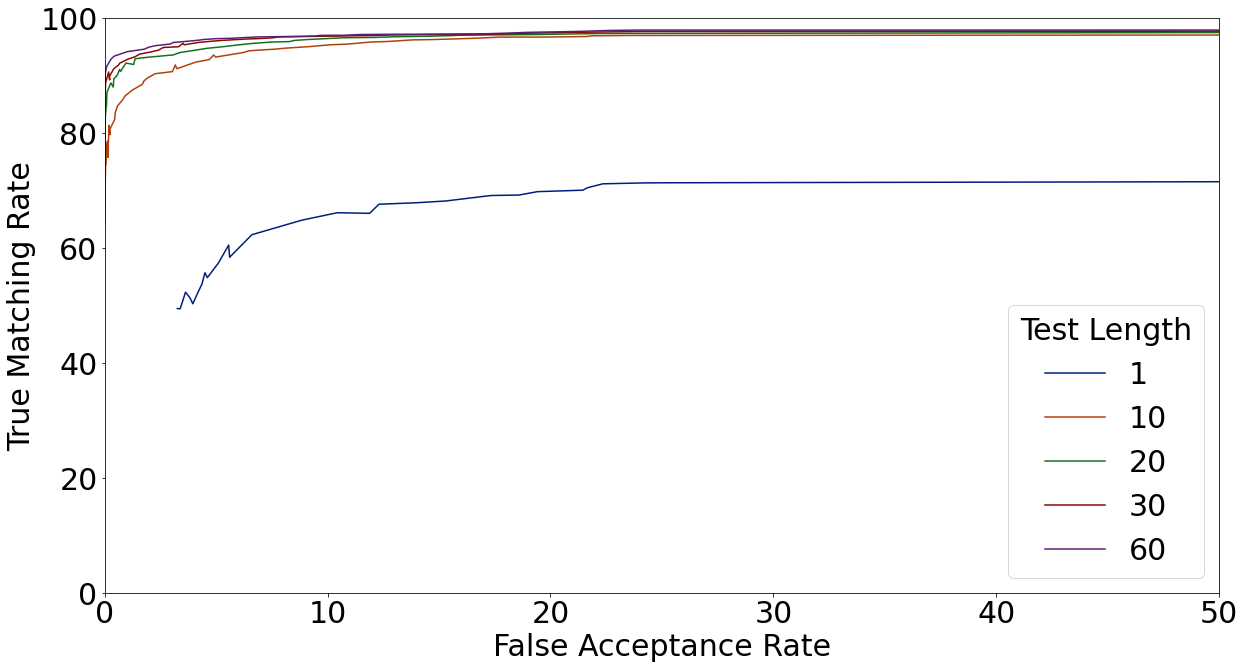

In [57]:
results = pickle.load(open('./results/tmp_far1.p','rb'))

def get_tmr_far(df):
    tmp = df[['score','user']].values
    far = np.mean(tmp[tmp[:,1]<0,0])
    tmr = np.mean(tmp[tmp[:,1]>=0,0])
    t = df['test_length'].values[0]
    threshold = df['threshold'].values[0]
    iteration = df['iteration'].values[0]
    return pd.DataFrame([[t,threshold,iteration,far,tmr]],columns=['test_length','threshold','iteration','FAR','TMR'])
df = results.groupby(['test_length','threshold','iteration'],as_index=False).apply(get_tmr_far)

df_final = df.groupby(['test_length','threshold'],as_index=False).max()

import seaborn as sns
import matplotlib.pyplot as plt
# df_final
df_final['FAR'] = df_final['FAR'].apply(lambda a:1-a)
# df_final['FAR'] = df_final['FAR'].apply(lambda a:a*.5)
df_final['FAR'] = df_final['FAR'].apply(lambda a:a*.5 if a<.5 else a)
df_final['FAR'] = df_final['FAR'].apply(lambda a:a*100)
df_final['TMR'] = df_final['TMR'].apply(lambda a:a*100)
df_final['Test Length'] = df_final['test_length'].apply(lambda a:a)
df_final = df_final[df_final.test_length.isin([1,10,20,30,60])]
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(18,10))
plot = sns.lineplot(x='FAR',y='TMR',hue='Test Length',data=df_final,dashes=False,palette='dark')
plt.ylabel('True Matching Rate')
plt.xlabel('False Acceptance Rate')
plt.xlim([0,50])
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('./images/FARvsTMR.png')
plt.show()

In [58]:
df_final = df_final[['Test Length','threshold','FAR','TMR']]

In [59]:
df_final.to_csv('./data/far_vs_tmr_walking_moral_vs_mperf1.csv')